In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import ellc

In [2]:
plt.style.use('notebook')

In [3]:
lit_period = 51.4213
lit_t0 = 2458901.6949978997

In [4]:
ref_rv = 2400000
btjd = 2457000

x_song, y_song, y_song_err = np.loadtxt('data/RV/SONG.txt', usecols=(0,1,2)).T
# x_bischoff, y_bischoff = np.loadtxt('data/RV/bischoff_rv_fixed_time.txt', usecols=(0,1)).T
time, flux, flux_err = np.loadtxt('data/photometry/tess_corrected.txt', usecols=(0,1,2)).T

# Correct all to the same reference time
time += btjd
x_song += ref_rv
# x_bischoff += btjd

No handles with labels found to put in legend.


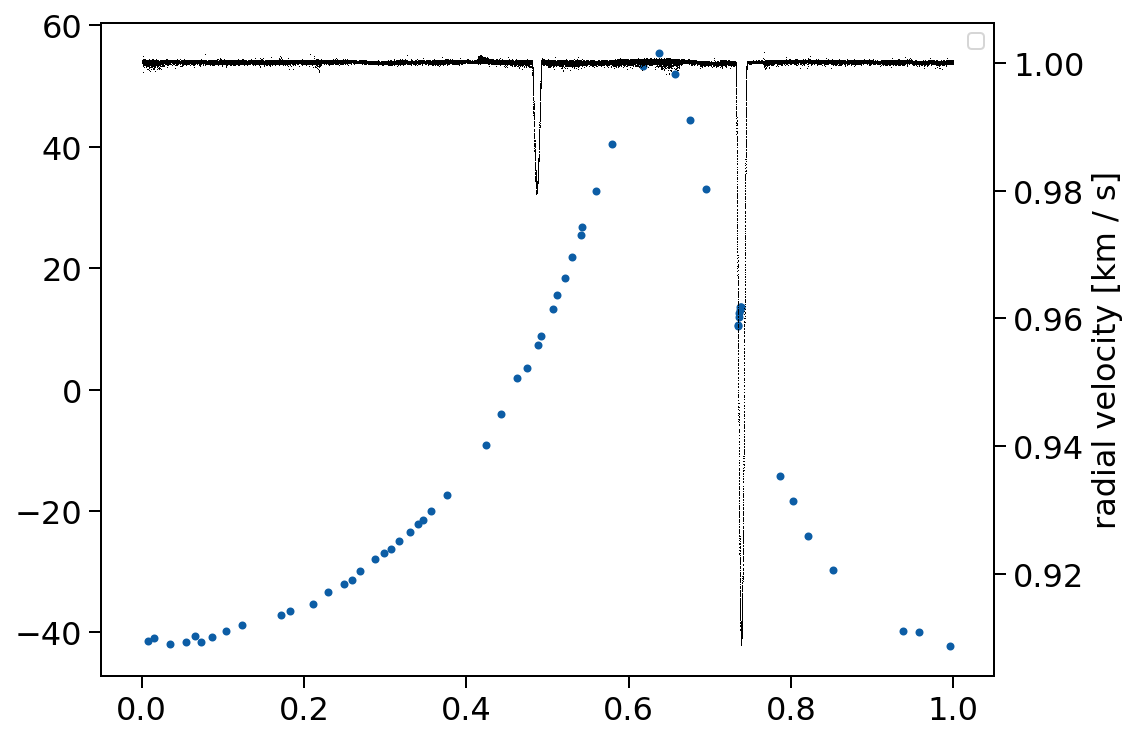

In [5]:
x_song = np.ascontiguousarray(x_song, dtype=np.float64)
y_song = np.ascontiguousarray(y_song, dtype=np.float64)

plt.plot(x_song % lit_period / lit_period, y_song, '.')
# plt.plot(x_bischoff % lit_period / lit_period, y_bischoff, '.')

ax2 = plt.twinx()
ax2.plot(time % lit_period / lit_period, flux, ',k')
ax2.set(ylabel='Flux')

plt.legend(fontsize=10)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

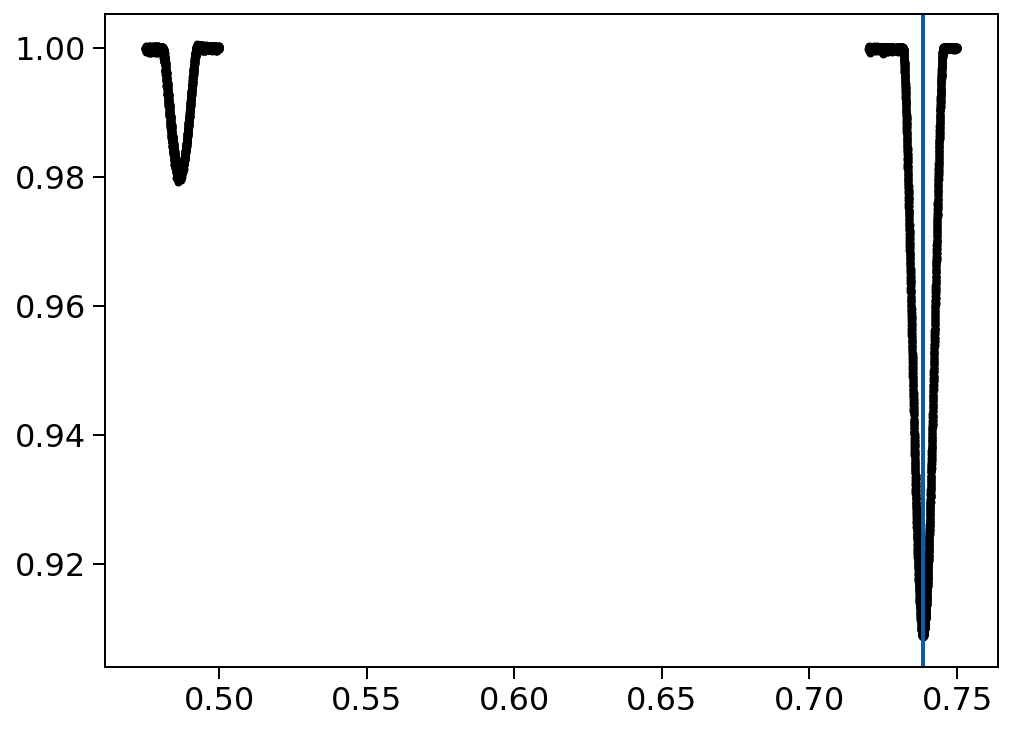

In [42]:
fold =  time % lit_period / lit_period
t0 = lit_t0 % lit_period / lit_period
m = ((fold < 0.50) & (fold > 0.475)) | ((fold > 0.72) & (fold < 0.75))
plt.plot(fold[m], flux[m], '.k')
plt.axvline(t0)
# plt.plot(fold, flux)

In [43]:
def rv_model(params, x):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammav, q11, q12, q21, q22, domdt, loglc, logrv = params
    r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    rv = ellc.rv(x,t_zero=t0,
                radius_1=r1, radius_2=r2,
                incl=incl,
                sbratio=sbratio, shape_1='sphere', shape_2='sphere',
                period=period, f_c=f_c, f_s=f_s,# q=q,
                a=sma,)
    return rv[0] + gammav

# def lnprior(params):
#     period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammav, q11, q12, q21, q22, domdt, loglc, logrv = params
#     r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
#     if (0 < q11 < 1) & (0 < q12 < 1) & (0 < q21 < 1) & (0 < q22 < 1) & (70 < incl < 90) & (sbratio < 1.5) & ((t0_guess-1) < t0 < (t0_guess+1)):
#         return 0.
#     else:
#         return -np.inf

def prior_transform(theta):
    transformed = []
    for param, bound in zip(theta, bounds):
        transformed.append(param * (bound[1] - bound[0]) + bound[0])
    return transformed
    
def q_to_u(q1, q2):
    return 2*np.sqrt(q1)*q2, np.sqrt(q1)*(1 - 2*q2)

def lc_model(params, x):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammav, q11, q12, q21, q22, domdt, loglc, logrv = params
    r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    
    u11, u12 = q_to_u(q11,q12)
    u21, u22 = q_to_u(q21,q22)

    t0p = t0 % period / period
    
    lc = ellc.lc(x,t_zero=t0p,
                radius_1=r1, radius_2=r2,
                incl=incl,
                sbratio=sbratio, shape_1='sphere', shape_2='sphere',
                period=1, f_c=f_c, f_s=f_s,
                 # Limb darkening
                ld_1='quad', ld_2='quad', ldc_1=[u11, u12], ldc_2=[u21,u22],
                a=sma,
                domdt=domdt,)
    return lc# + mean    
    
def lnlike(params, x, y, yerr, x_rv, y_rv, yerr_rv):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammav, q11, q12, q21, q22, domdt, loglc, logrv = params
#     lp = lnprior(params)
#     if not np.isfinite(lp):
#         return -np.inf
#     LC
    
    fold =  x % period / period
    m = ((fold < 0.50) & (fold > 0.475)) | ((fold > 0.72) & (fold < 0.75))
    
    model_flux = lc_model(params, fold[m])
    sigma2 = yerr[m] ** 2+ model_flux ** 2 * np.exp(2 * loglc)
    ln_lc = -0.5*np.sum((y[m]-model_flux)**2/sigma2 + np.log(sigma2))

    # RV SONG
    model_rv = rv_model(params, x_rv)
    sigma2 = yerr_rv ** 2 + model_rv ** 2 * np.exp(2 * logrv)
    ln_rv = -0.5*np.sum((y_rv-model_rv)**2/sigma2 + np.log(sigma2))
    
    # RV BISCHOFF
#     model_rv = rv_model(params, x_rv)
#     sigma2 = yerr_rv ** 2 + model_rv ** 2 * np.exp(2 * logrv)
#     ln_rv = -0.5*np.sum((y_rv-model_rv)**2/sigma2 + np.log(sigma2))

    return ln_rv + ln_lc
    
from scipy.optimize import minimize
nll = lambda *args: -lnlike(*args)

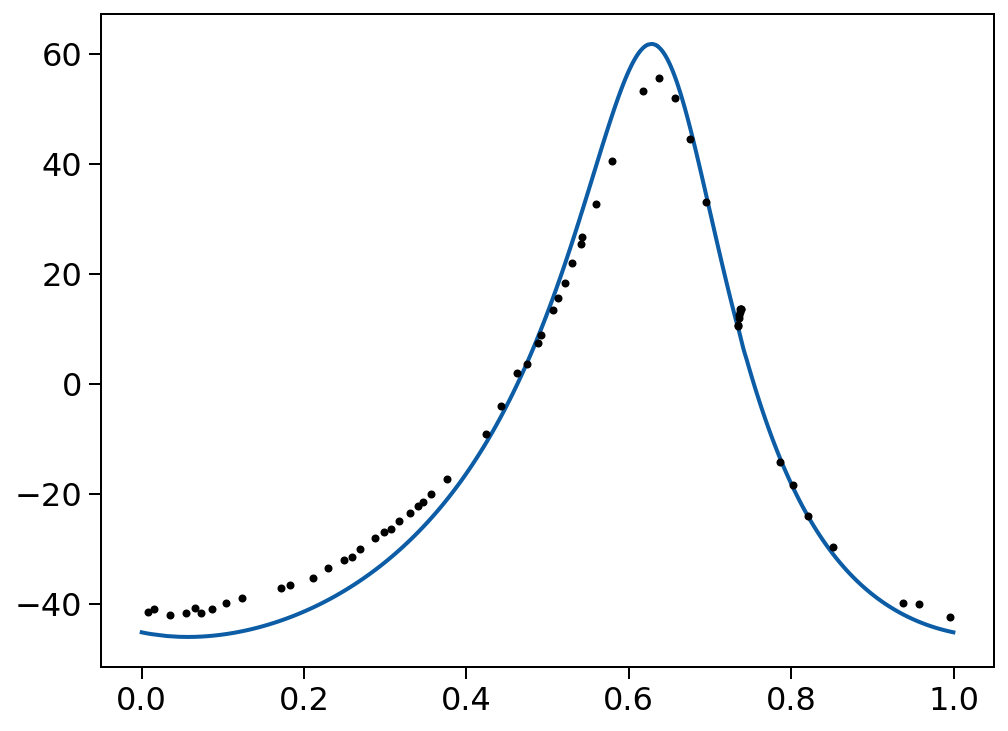

In [44]:
f_c, f_s = 0.6071025773236461, 0.24107770657401392, 

bounds = [
    (50,52), #period
    (0.01, 0.1), # rsum
    (0.1, 0.9), #rratio
    (80, 90), #incl
    (0.1, 0.5),#sbratio
    (lit_t0-1, lit_t0+1), #t0
    (f_c-0.1, f_c+0.1), #fc
    (f_s-0.1, f_s+0.1),#ds
#     (-10,10),#mean
    (10,150), #sma
    (-20,-5),#gammav
    (0,1),
    (0,1),
    (0,1),
    (0,1),
    (-1,1),#domdt 
    (-10,10),#mean
    (-10,10),#mean
]

params = np.array([
    5.14192040e+01, # Period
    7.17949071e-02, # Rsum
    6.28722905e-01, # Rratio
    8.62150418e+01, # Incl
    6.91829286e-01, # Sbratio
    lit_t0, # t0
    6.20730605e-01, # fc
    1.60481296e-01, # fs
#     0., #logf
#     0., #mean
    100, #sma
    -13.53, #gammav
    2.68060970e-01, # q11
    4.55712020e-01, # q12
    8.30538026e-01, # q21
    5.82431661e-02, # q22
    0., #domdt
    0.,
    0.,
])

test_time = np.linspace(x_song[0], x_song[-1], 10000)
a = rv_model(params, test_time)
# b = lc_model(params, time)
fold = test_time % lit_period / lit_period
sort = np.argsort(fold)

plt.plot(fold[sort], a[sort])
plt.plot(x_song % lit_period / lit_period, y_song, '.k')
# plt.plot(x_bischoff % lit_period / lit_period, y_bischoff, '.')
plt.show()

In [46]:
from scipy.optimize import differential_evolution

soln = differential_evolution(nll, bounds, args=(time, flux, flux_err, x_song, y_song, y_song_err))

test_time = np.linspace(x_song[0], x_song[-1], 10000)
test_time = x_song
a = rv_model(soln.x, test_time)
# b = lc_model(params, time)
fold = test_time % lit_period / lit_period
sort = np.argsort(fold)

plt.plot(fold[sort], a[sort])
plt.plot(x_song % lit_period / lit_period, y_song, '.k')
# plt.plot(x_bischoff % lit_period / lit_period, y_bischoff, '.')
# plt.xlim(0.73, 0.745)
# plt.ylim(0, 15)

plt.xlabel('Orbital phase')
plt.ylabel('RV [km/s]')

plt.show()

KeyboardInterrupt: 

In [13]:
# import dynesty
import dynesty

print('dynesty version: {}'.format(dynesty.__version__))

nlive = 1024      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = len(params)         # two parameters
sample = 'unif'   # uniform sampling

from dynesty import NestedSampler

sampler = NestedSampler(lnlike, prior_transform, ndims,
                        #bound=bound, sample=sample, nlive=nlive,
                       logl_args=(time, flux, flux_err, x_song, y_song, y_song_err))

# t0 = time()
sampler.run_nested(print_progress=True) # don't output progress bar
# t1 = time()

# timedynesty = (t1-t0)

dynesty version: 1.0.1


8837it [10:29, 14.05it/s, +500 | bound: 121 | nc: 1 | ncall: 194598 | eff(%):  4.798 | loglstar:   -inf < -57.674 <    inf | logz: -74.780 +/-  0.261 | dlogz:  0.001 >  0.509]


In [14]:
from dynesty import plotting as dyplot

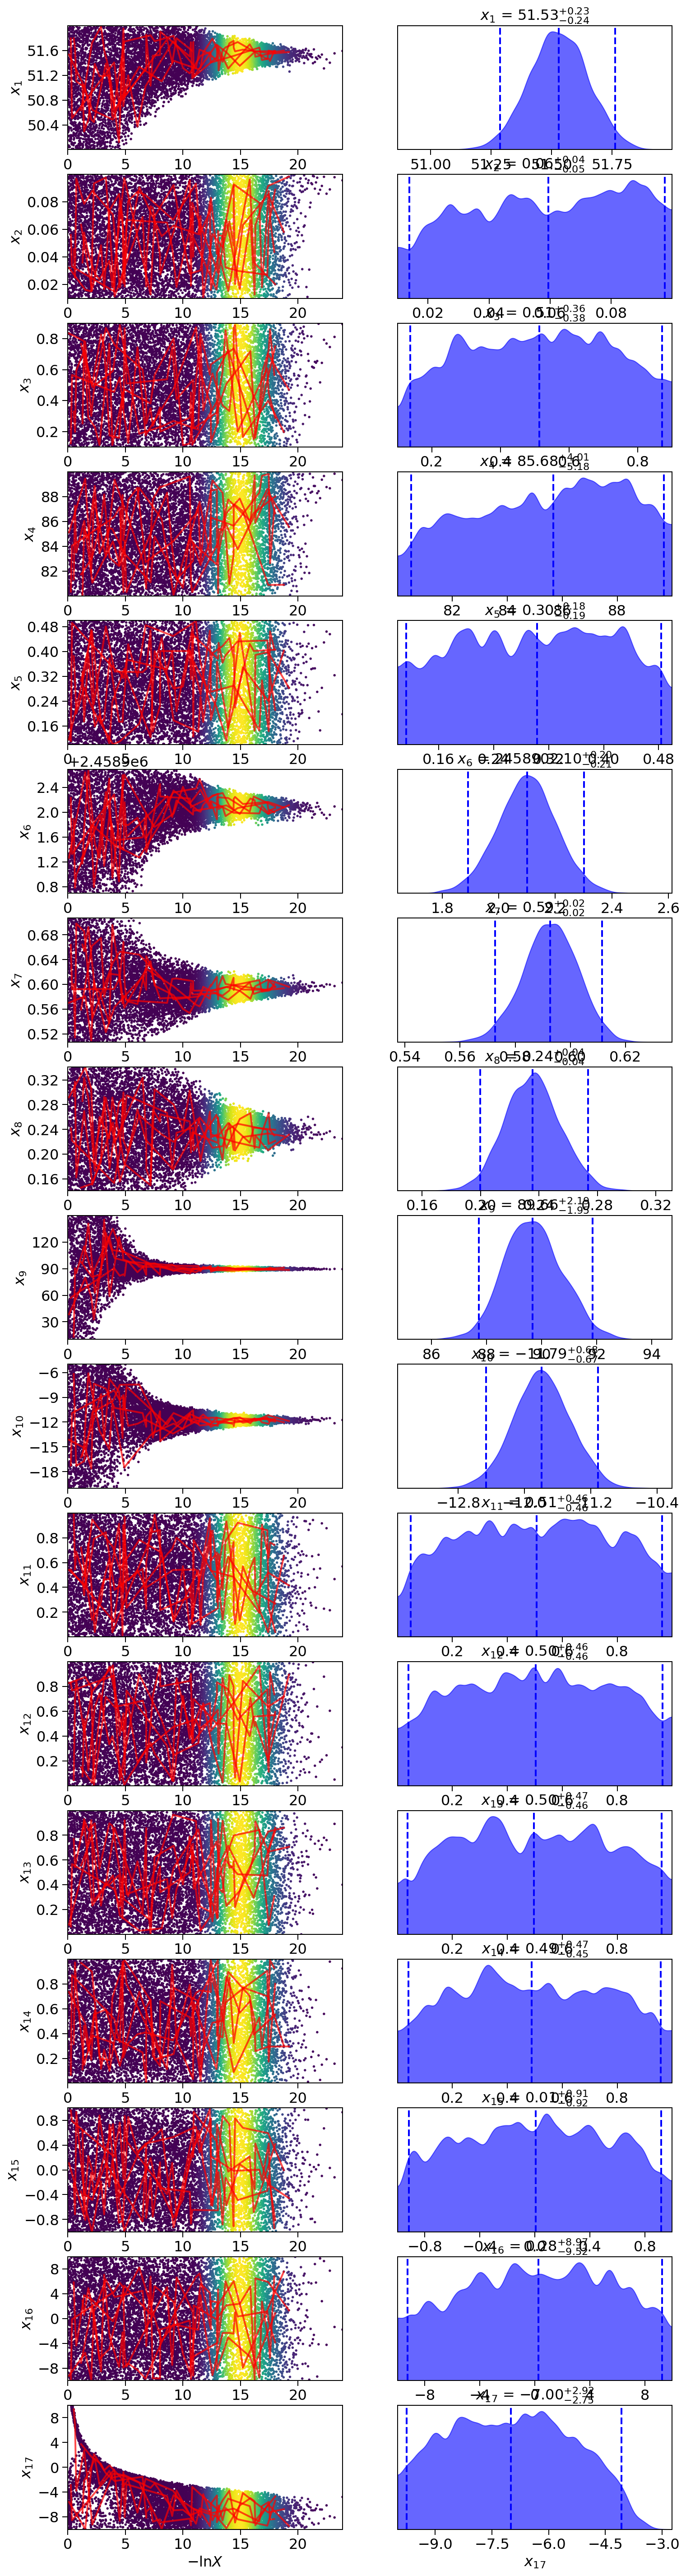

In [15]:
fig, axes = dyplot.traceplot(sampler.results, #truths=np.zeros(ndim),
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(5)
                            )

In [ ]:
    (50,52), #period
    (0.01, 0.1), # rsum
    (0.1, 0.9), #rratio
    (80, 90), #incl
    (0.1, 0.5),#sbratio
    (lit_t0-1, lit_t0+1), #t0
    (f_c-0.1, f_c+0.1), #fc
    (f_s-0.1, f_s+0.1),#ds
#     (-10,10),#mean
    (10,150), #sma
    (-20,-5),#gammav
    (0,1),
    (0,1),
    (0,1),
    (0,1),
    (-1,1),#domdt 
    (-10,10),#mean
    (-10,10),#mean

In [20]:
np.median(sampler.results['samples'], axis=0)

array([ 5.14664406e+01,  5.68287958e-02,  5.04400797e-01,  8.51908959e+01,
        2.98052558e-01,  2.45890207e+06,  5.93023246e-01,  2.37336942e-01,
        8.97999414e+01, -1.17374603e+01,  5.04175391e-01,  4.94746268e-01,
        5.02227718e-01,  5.05339012e-01, -4.27157889e-03, -4.03007422e-02,
       -5.50676881e+00])

In [ ]:
fg, ax = dyplot.cornerpoints(sampler.results, cmap='plasma', #truths=np.zeros(ndim),
                             kde=False, #fig=(fig, axes[:, :2])
                            )

In [12]:
time, flux, flux_err

(array([2458683.35217053, 2458683.35355938, 2458683.35494823, ...,
        2458926.49209686, 2458926.49348573, 2458926.4948746 ]),
 array([0.99986903, 0.99991772, 0.9999815 , ..., 1.0002165 , 1.00010181,
        0.99950559]),
 array([4.60767660e-05, 4.60741539e-05, 4.60677875e-05, ...,
        4.56911002e-05, 4.56827620e-05, 4.56753878e-05]))

KeyboardInterrupt: 

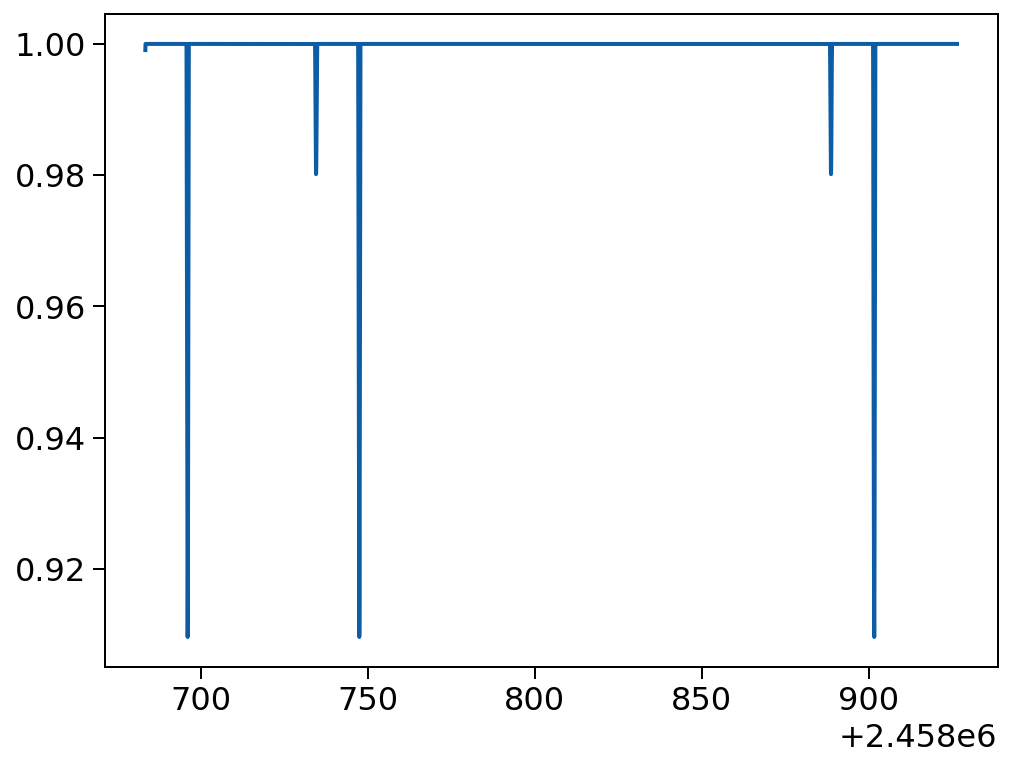

In [15]:
plt.plot(time, lc_model(params, time))

In [ ]:
plt.errorbar(x_song % lit_period / lit_period, y_song - a, yerr=y_song_err, fmt='.k')

In [ ]:
b = lc_model(soln.x, time)
plt.plot(time % lit_period / lit_period, b, alpha=0.5)
plt.plot(time % lit_period / lit_period, flux, alpha=0.5)

# plt.xlim(0.4, 0.6)